## Plotting and Analyzing Learned Parameters of Trained BINN
#### Uses BINNCovasim Neural Network Model

In [181]:
import sys
sys.path.append('../')

from Modules.Utils.Imports import *
from Modules.Models.BuildBINNs import BINNCovasim
from Modules.Models.BuildBINNs import chi as chi_func_arr
from Modules.Utils.ModelWrapper import ModelWrapper

import Modules.Utils.PDESolver as PDESolver
lasso_ODE = PDESolver.lasso_ODE

from Modules.Utils.DRUMS_Lasso import DRUMS_Lasso
import Modules.Loaders.DataFormatter as DF
from utils import get_case_name, lasso_parameter_fitting
import seaborn as sns
# sns.set(font_scale=1.2, style='white')
from sklearn import linear_model
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from scipy.integrate import solve_ivp 
import warnings
warnings.filterwarnings("ignore", message="Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions")



In [182]:
device = torch.device(GetLowestGPU(pick_from=[0,1,2,3]))
# helper functions
def to_torch(x):
    return torch.from_numpy(x).float().to(device)
def to_numpy(x):
    return x.detach().cpu().numpy()

Device set to cpu


In [183]:
from scipy.stats import beta as bt

def chi_func(t, chi_type):
    eff_ub = 0.3
    if chi_type == 'linear':
        rate = eff_ub / 75
        if t < 75:
            factor = rate * (t + 1)
        elif 75 <= t < 150:
            factor = eff_ub - rate * (t - 75 + 1)
        else:
            factor = 0
        # factor = torch.where(t < 30.0, rate * t, eff_ub * torch.ones_like(t))
    elif chi_type == 'sin':
        rad_times = t * np.pi / 40.
        factor = 0.3 * (1 + np.sin(rad_times)) / 2
    elif chi_type == 'piecewise':
        a, b = 3, 3
        t_max = 159
        max_val = bt.pdf(0.5, a, b, loc=0, scale=1)
        if t < 80:
            factor = bt.pdf(t / t_max, a, b, loc=0, scale=1) * eff_ub / max_val
        elif t >= 120:
            factor = bt.pdf((t - 40) / t_max, a, b, loc=0, scale=1) * eff_ub / max_val
        else:
            factor = eff_ub
    elif chi_type == 'constant':
        factor = eff_ub
    return factor


In [184]:
# instantiate BINN model parameters and path
path = '../Data/covasim_data/drums_data/'
# path = '../Data/covasim_data/xin_data/'

population = int(200e3)
test_prob = 0.1
trace_prob = 0.3
keep_d = True
retrain = False
dynamic = True
masking = 0
multiple = False
parallelb = False
n_runs = 1024
chi_type = 'piecewise'

case_name = get_case_name(population, test_prob, trace_prob, keep_d, dynamic=dynamic, chi_type=chi_type)
# yita_lb, yita_ub = 0.2, 0.4

In [185]:
if not masking==0:
    if masking==1:
        case_name = case_name + '_maskingthresh'
    elif masking==2:
        case_name = case_name + '_maskinguni'
    elif masking==3:
        case_name = case_name + '_maskingnorm'

if multiple:
    params = DF.load_covasim_data(path, population, test_prob, trace_prob, keep_d, case_name + '_' + str(n_runs), plot=False)
else:
    params = DF.load_covasim_data(path, population, test_prob, trace_prob, keep_d, case_name, plot=False)

In [186]:
# split into train/val and convert to torch
# multiple==True and parallelb==False means that data is a list and not normalized
if multiple and not parallelb:
    data = np.mean(params['data'], axis=0)
    data = (data / params['population'])
# multiple==True and parallelb==True means that the data is a 2d array and normalized
elif multiple and parallelb:
    data = params['data']
# otherwise, the data is from a single simulation and is not normalized
else:
    data = params['data']
    data = (data / params['population']).to_numpy()
    
params.pop('data')

N = len(data)
t_max = N - 1
t = np.arange(N)

split = int(0.8*N)
p = np.random.permutation(N)

x_train = to_torch(p[:split][:, None]/(N-1))
y_train = to_torch(data[p[:split]])
x_val = to_torch(p[split:][:, None]/(N-1))
y_val = to_torch(data[p[split:]])

tracing_array = params['tracing_array']

In [187]:
#mydir = '../models/covasim/2023-07-06_23-47-16' # no masking, 200e3 pop, dynamic piecewise, keepd, 1024 avg., 50e3 epochs, lr=1e4
mydir = '../models/covasim/2023-07-12_11-00-45' # no masking, 200e3 pop, dynamic piecewise, keepd, 1024 avg., 50e3 epochs, lr=1e4

In [188]:
binn = BINNCovasim(params, t_max, tracing_array, keep_d=keep_d).to(device)
parameters = binn.parameters()
model = ModelWrapper(binn, None, None, save_name=os.path.join(mydir, case_name))

In [189]:
# load model weights
# model.save_name = '../Weights/'
# model.save_name += case_name
if retrain:
    model.save_name += '_retrain'
model.save_name += '_best_val'
model.load(model.save_name + '_model', device=device)
save_path = model.save_folder
# grab initial condition
u0 = data[0, :].copy()

In [190]:
# # if not folder for plots exists, make them
# if not os.path.exists(model.save_folder + '\\eta_plots'):
#     os.makedirs(os.path.join(model.save_folder, 'eta_plots'))
#     os.makedirs(os.path.join(model.save_folder, 'beta_plot'))
#     os.makedirs(os.path.join(model.save_folder, 'tau_plot'))
#     os.makedirs(os.path.join(model.save_folder, 'lasso_plots'))

In [191]:
# grab value ranges
yita_lb, yita_ub = model.model.yita_lb, model.model.yita_ub
beta_lb, beta_ub = model.model.beta_lb, model.model.beta_ub
tau_lb, tau_ub = model.model.tau_lb, model.model.tau_ub

In [192]:
# learned contact_rate function
def contact_rate(u):
    res = binn.eta_func(to_torch(u)) # [:,[0,3,4]]
    return to_numpy(res)
# learned tracing rate function
def beta(u):
    res = binn.beta_func(to_torch(u))
    return to_numpy(res)
# learned diagnoses rate of quarantined individuals
def tau(u):
    res = binn.tau_func(to_torch(u))
    return to_numpy(res)

In [193]:
#%% visualization for eta
s_min, s_max = data[:,0].min(), data[:,0].max()
a_min, a_max = data[:,3].min(), data[:,3].max()
y_min, y_max = data[:,4].min(), data[:,4].max()
say_min, say_max = (data[:,0] + data[:,3] + data[:,4]).min(), (data[:,0] + data[:,3] + data[:,4]).max()
chi_min, chi_max = 0.0, params['eff_ub']

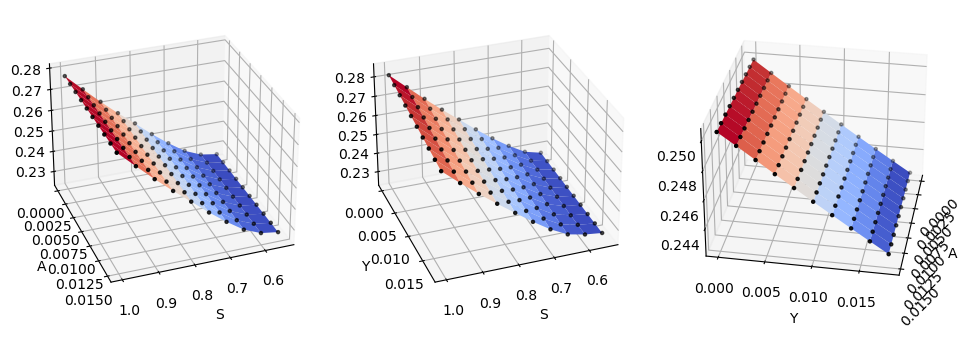

In [194]:
# grid for inputs S, A
a_grid = np.linspace(s_min, s_max, 10)
# grid for inputs S, Y
b_grid = np.linspace(a_min, a_max, 10)
# grid for inputs A, Y
c_grid = np.linspace(y_min, y_max, 10)

labels = ['S', 'A', 'Y']
fig = plt.figure(figsize=(10,7))
# for each of the 3 input combinations
for i in range(3):
    if i == 0:
        X, Y = np.meshgrid(a_grid, b_grid)
        Z = np.ones_like(X) * c_grid.mean()
        # set x and y labels to S and A
        x_label, y_label = labels[0], labels[1]
    elif i == 1:
        X, Z = np.meshgrid(a_grid, c_grid)
        Y = np.ones_like(X) * b_grid.mean()
        # set x and y labels to S and Y
        x_label, y_label = labels[0], labels[2]
    else:
        Y, Z = np.meshgrid(b_grid, c_grid)
        X = np.ones_like(Y) * a_grid.mean()
        # set x and y labels to A and Y
        x_label, y_label = labels[1], labels[2]

    # grid of S, A, Y values
    u_grid = np.stack([np.ravel(X), np.ravel(Y), np.ravel(Z)], axis=1)
    # result of evaluating eta with inputs S, A, Y
    res = contact_rate(u_grid)
    # transfom eta(S, A, Y) into the interval previously defined
    res = yita_lb + (yita_ub - yita_lb) * res
    res = res[:,0].reshape(X.shape)
    res = np.round(res, decimals=6)
    
    ax = fig.add_subplot(1, 3, i + 1, projection='3d')
    if i == 0:
        ax.plot_surface(X, Y, res, cmap=cm.coolwarm, alpha=1)
        ax.scatter(X.reshape(-1), Y.reshape(-1), res.reshape(-1), s=5, c='k')
        ax.view_init(30,70)
    elif i == 1:
        ax.plot_surface(X, Z, res, cmap=cm.coolwarm, alpha=1)
        ax.scatter(X.reshape(-1), Z.reshape(-1), res.reshape(-1), s=5, c='k')
        ax.view_init(30,70)
    else:
        ax.plot_surface(Y, Z, res, cmap=cm.coolwarm, alpha=1)
        ax.scatter(Y.reshape(-1), Z.reshape(-1), res.reshape(-1), s=5, c='k')
        plt.setp(ax.get_xticklabels(), rotation=45) # , ha="right", rotation_mode="anchor"
        ax.view_init(30,10)

    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    
plt.tight_layout(pad=2)
#plt.savefig(os.path.join(save_path + '\\eta_plots', case_name + '_parameter_NN_eta_DRUMS' + '.png'), dpi=300, bbox_inches='tight')
plt.show()
plt.close()

/var/folders/qr/bhw9x9312cv578trmztshbf00000gn/T/ipykernel_77886/3523491244.py:25: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout(pad=2)


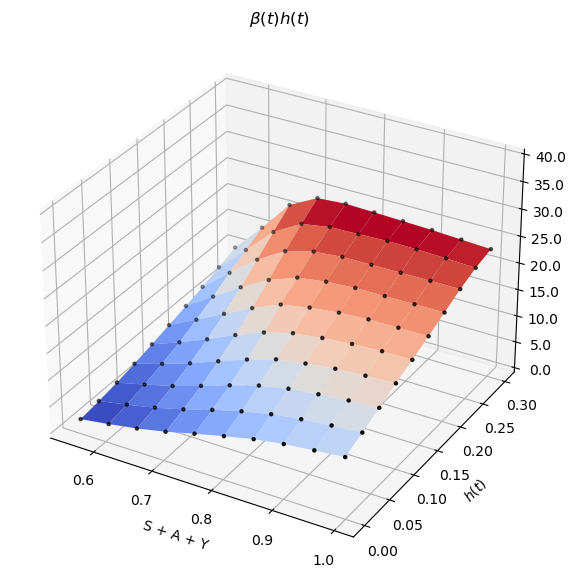

In [195]:
#%% visualization for beta
#chi_min, chi_max = 0.05, params['eff_ub']
# chi_grid = np.linspace(chi_min, chi_max, 10)

a_grid = np.linspace(say_min, say_max, 10) # S + A + Y
b_grid = np.linspace(chi_min, chi_max, 10)
labels = ['S + A + Y', r'$h(t)$']

X, Y = np.meshgrid(a_grid, b_grid)
x_label, y_label = labels[0], labels[1]
u_grid = np.stack([np.ravel(X), np.ravel(Y)], axis=1)
res = beta(u_grid) * params['n_contacts'] # * u_grid[:, [1]] *
res = res[:,0].reshape(X.shape)
res = np.round(res, decimals=6)
#res = beta_lb + (beta_ub - beta_lb) * res

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.plot_surface(X, Y, res, cmap=cm.coolwarm, alpha=1)
ax.scatter(X.reshape(-1), Y.reshape(-1), res.reshape(-1), s=5, c='k')
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.set_zticks(np.arange(0,40.1, 5), np.arange(0,40.1, 5))
ax.set_title(r'$\beta(t)h(t)$')
plt.tight_layout(pad=2)

#plt.savefig(os.path.join(save_path + '\\beta_plot', case_name + '_parameter_NN_beta_DRUMS' + '.png'), dpi=300, bbox_inches='tight' )
plt.show()
plt.close()

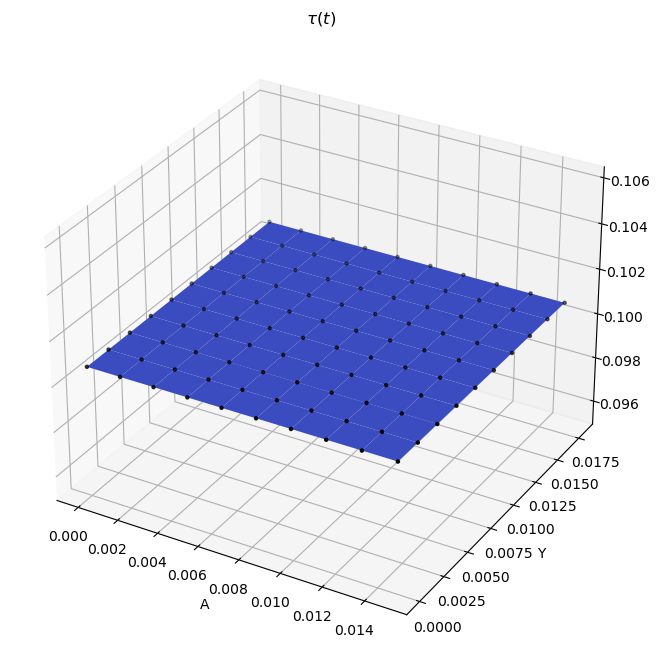

In [196]:
#%% visualization for tau

a_grid = np.linspace(a_min, a_max, 10)
b_grid = np.linspace(y_min, y_max, 10)
labels = ['A', 'Y']

X, Y = np.meshgrid(a_grid, b_grid)
x_label, y_label = labels[0], labels[1]
u_grid = np.stack([np.ravel(X), np.ravel(Y)], axis=1)
res = tau(u_grid)
res = res[:,0].reshape(X.shape)
res = tau_lb + (tau_ub - tau_lb) * res # scaling
res = np.round(res, decimals=4)

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.plot_surface(X, Y, res, cmap=cm.coolwarm, alpha=1)
ax.scatter(X.reshape(-1), Y.reshape(-1), res.reshape(-1), s=5, c='k')
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.set_title(r'$\tau(t)$')
plt.tight_layout(pad=2)
#plt.savefig(os.path.join(save_path + '\\tau_plot', case_name + '_parameter_NN_tau_DRUMS' + '.png'), dpi=300, bbox_inches='tight')
plt.show()
plt.close()


In [197]:

chi_array = np.array([])
for item in t:
    chi_array = np.append(chi_array, chi_func(item, "piecewise"))

#print(chi_array)

In [198]:
 
warnings.filterwarnings("ignore", message="Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated.")

# lasso regression to learn symbolic terms from parameter NN
def get_samples_ct(u):
    s, a, y =  u[:, 0][:, None], u[:, 1][:, None], u[:, 2][:, None]
    candidates = [s, s**2, a, y] # s related terms
    # candidates += [a]
    # candidates += [y]
    # candidates += [chi]
    candidates = np.concatenate(candidates, axis=1)
    return candidates

def get_samples_beta(u):
    drf, chi = u[:, 0][:, None], u[:, 1][:, None]
    candidates = [drf, chi] # , chi**2
    candidates = np.concatenate(candidates, axis=1)
    return candidates

def get_samples_tau(u):
    a, y = u[:, 0][:, None], u[:, 1][:, None]
    candidates = [a, y]
    candidates = np.concatenate(candidates, axis=1)
    return candidates

s_grid = np.linspace(s_min, s_max, 10)
a_grid = np.linspace(a_min, a_max, 10)
y_grid = np.linspace(y_min, y_max, 10)

#Eta -------------------------
train_x1 = np.array(np.meshgrid(s_grid, a_grid, y_grid)).T.reshape(-1,3)


data_x1 = get_samples_ct(train_x1)

#data_y1 = contact_rate(train_x1)
data_y1 = contact_rate(data[:,[0,3,4]])
data_y1 = data_y1[:,0][:, None]

eta_rhs_values = {
    'S' : data[:,0],
    'A' : data[:,3],
    'Y' : data[:,4],
}

results_eta = DRUMS_Lasso(input_dict = eta_rhs_values, lhs_values = data_y1, alphas = np.array([0])) 

print()
print()
print("Equation for Eta: " + str(results_eta['Equation']))
print("Eta MSE: " + str(results_eta["MSE"]))
print()
print()
#------------------------------



#Beta--------------------------


say_grid = np.linspace(say_min, say_max, 10)

chi_grid = np.linspace(chi_min, chi_max, 10)

# Create meshgrid from the 1D arrays
SAY, XX = np.meshgrid(say_grid, chi_grid)   #SAY is the sum S + A + Y

# Reshape and combine the arrays
data_x2 = np.column_stack((SAY.ravel(), XX.ravel()))
data_y2 = beta(data_x2)


say_sum = np.add(data[:,0], data[:,3])
say_sum = np.add(say_sum, data[:,4])


data_beta = beta(np.concatenate([say_sum[:, None], chi_array[:, None]], axis = 1))





beta_rhs_values = {
    'SAY' : data_x2[:,0],
    'X' : data_x2[:,1]
}



results_beta = DRUMS_Lasso(input_dict = beta_rhs_values, lhs_values = data_y2, alphas=np.array([0])) 

print()
print()
print("Equation for Beta: " + str(results_beta['Equation']))
print("Beta MSE: " + str(results_beta["MSE"]))
print()
print()

#----------------------------------






#Tau-------------------------------

labels = ['A', 'Y']

AA, YY = np.meshgrid(a_grid, y_grid)
data_x3 = np.column_stack((AA.ravel(), YY.ravel()))
data_tau = tau(data_x3)

data_tau = tau_lb + (tau_ub - tau_lb) * data_tau # scaling
data_tau = np.round(data_tau, decimals=4)

tau_rhs_values = {
    'A' : data_x3[:,0],
    'Y' : data_x3[:,1],
}
results_tau = DRUMS_Lasso(input_dict = tau_rhs_values, lhs_values = data_tau, alphas = np.array([0]))

# # Assuming you have a_grid, y_grid, data_x3, and data_y3 defined

# import numpy as np
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

# # Assuming you have a_grid, y_grid, data_x3, and data_y3 defined

# # Reshape the data for 3D plotting
# A, Y = np.meshgrid(a_grid, y_grid)
# Z = data_tau.reshape(len(a_grid), len(y_grid))  # Reshape data_tau to match A and Y dimensions

# # Create a 3D figure
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# # Plot the data as a 3D surface plot
# ax.plot_surface(A, Y, Z, cmap='viridis')

# # Set labels and title
# ax.set_xlabel('A')
# ax.set_ylabel('Y')
# ax.set_zlabel('tau')
# ax.set_title('3D Plot of tau in terms of A and Y')

# # Show the plot
# plt.show()



print()
print()
print("Equation for Tau: " + str(results_tau['Equation']))
print("Tau MSE: " + str(results_tau["MSE"]))
print(results_tau["Lasso"].coef_)
print(results_tau["Lasso"].intercept_)
print(results_tau["Terms"])




/Users/jordanklein22/opt/anaconda3/envs/Drums_reu_2023/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:1568: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jordanklein22/opt/anaconda3/envs/Drums_reu_2023/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000192560116225279, tolerance: 0.00018150869659086104
  model = cd_fast.enet_coordinate_descent_gram(
/Users/jordanklein22/opt/anaconda3/envs/Drums_reu_2023/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00019747754636237607, tolerance: 0.00018150869659086104
  model = cd_fast.ene

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/jordanklein22/opt/anaconda3/envs/Drums_reu_2023/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent_gram(
/Users/jordanklein22/opt/anaconda3/envs/Drums_reu_2023/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent_gram(
/Users/jordanklein22/opt/anaconda3/envs/Drums_reu_2023/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent_gram(
/Users/jordanklein22/opt/anaconda3/envs/Drums_reu_2023/

In [199]:
def lasso_ODE_test(t, y, lasso_tup : tuple, params : dict, t_max, chi_type):
# def lasso_ODE_test(t, y, *args):

    '''
    t (float)           : initial time  **check me, should this be initial time or tuple of time?
    y (list)            : list of initial conditions (floats) for STEAYDQRF
    lasso_tup (tuple)   : tuple of lasso objects for eta beta and tau   **check me
    params (dict)       : parameters of the Covasim model I think this is from the learned MLP, maybe I dont need these **check me
    t_max (float)       : max of time (last day of simulation)  **check me, if time is a tuple, do I need this?
    chi_type
    '''

    population = params['population']
    alpha = params['alpha']
    gamma = params['gamma']
    mu = params['mu']
    lamda = params['lamda']
    p_asymp = params['p_asymp']
    n_contacts = params['n_contacts']
    delta = params['delta']
    eff_ub = params['eff_ub']
    chi = chi_func(t, chi_type)

 
    eta_lasso, beta_lasso, tau_lasso = lasso_tup

    # evaluate the constant value of each parameter
    S, T, E, A, Y, D, Q, R, F = tuple(y)   #values at this specific time
   

    eta_poly = PolynomialFeatures(degree = 2, include_bias = True)
    eta_input = eta_poly.fit_transform(np.array([[S, A, Y]]))
    eta_input = eta_input[:,1:]
    eta_i = eta_lasso.predict(eta_input)    #eta value at this specific time

    beta_poly = PolynomialFeatures(degree = 2, include_bias = True)
    beta_input = beta_poly.fit_transform([[S+A+Y, chi]])
    beta_input = beta_input[:,1:]
    beta_i = beta_lasso.predict(beta_input)

    tau_poly = PolynomialFeatures(degree = 2, include_bias = True)
    tau_input = tau_poly.fit_transform([[A, Y]])
    tau_input = tau_input[:,1:]
    tau_i = tau_lasso.predict(tau_input)

    new_d = mu * Y +  tau_i * Q



    #beta_i = 0.25




    dS = - eta_i * S * (A + Y) -  beta_i * new_d *  n_contacts * S +  alpha * T

    dT = beta_i * new_d *  n_contacts * S -  alpha * T

    dE = eta_i * S * (A + Y) -  gamma * E

    dA =  p_asymp *  gamma * E -  lamda * A -  beta_i * new_d *  n_contacts * A

    dY = (1 -  p_asymp) *  gamma * E - ( mu +  lamda +  delta) * Y -  beta_i * new_d *  n_contacts * Y

    dD =  new_d -  lamda * D - delta * D

    dQ =  beta_i * new_d *  n_contacts * (A + Y) - (tau_i +  lamda + delta) * Q

    dR =  lamda * (A + Y + D + Q)

    dF =  delta * (Y + D + Q)

    result = [float(dS), float(dT), float(dE), float(dA), float(dY), float(dD), float(dQ), float(dR), float(dF)]

    return result



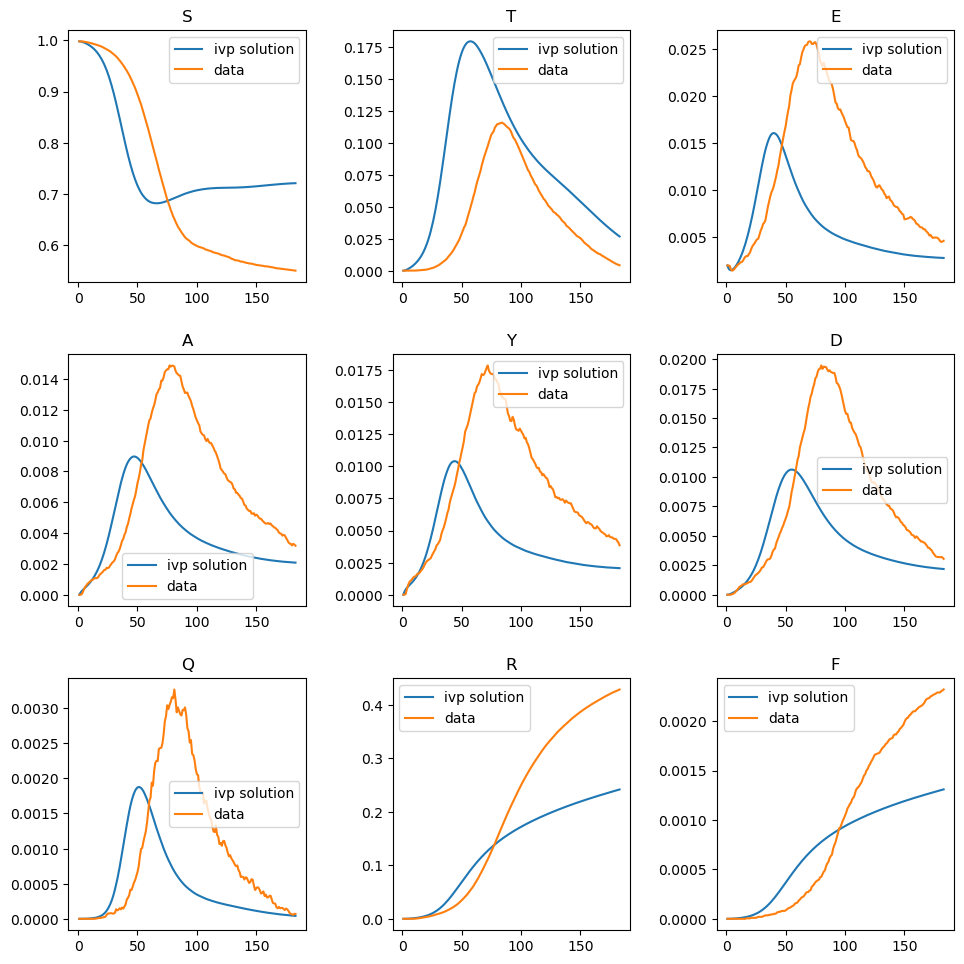

In [200]:
lasso_tup = (results_eta["Lasso"], results_beta["Lasso"], results_tau["Lasso"])

t_span = (1,183)
t0 = float(t_span[0])
t_max = t_span[1]
t_values = np.arange(t0, t_max + 1)
chi_type = "piecewise"



y0 = u0

LO_args = (lasso_tup, params, t_max, chi_type)


sol = solve_ivp(lasso_ODE_test, t_span, y0, t_eval=t_values, args=LO_args, method='RK45')



t_values = sol.t
s_val, t_val, e_val, a_val, y_val, d_val, q_val, r_val, f_val = sol.y
labellist = ["S", "T", "E", "A", "Y", "D", "Q", "R", "F" ]

sol_mat = np.matrix(sol.y).T
num_cols = sol_mat.shape[1]



# i = 0
# for item in sol.y:

#     plt.plot(t_values, item, label=labellist[i])
#     i +=1
# plt.xlabel('Time')
# plt.ylabel('solve_ivp sol')
# plt.legend()
# plt.show()


fig = plt.figure(figsize=(10, 10))

for i in range(num_cols):    
    ax = fig.add_subplot(3, 3, i+1) #subplot with n divided by 3 and rounded up num rows, 3 num cols and the element goes in the ith place
    ax.plot(t_values, sol_mat[:, i], label = "ivp solution")
    ax.plot(t_values, data[:,i] , label = "data")
    # ax.plot(t_values , beta_array, label = "beta")
    # ax.plot(t_values, chi_array, label = "chi")
    # ax.plot(t_values, say_sum, label = "S+A+Y")

    # ax.plot(t_values, eta_array * population, label = "eta")
    ax.set_title(labellist[i])

    fig.subplots_adjust(left=0, right=0.5, bottom=0, top=1)
    plt.legend()
    
plt.tight_layout(pad=2)
plt.show()


***Code Below not Operational - 06/24/2023***

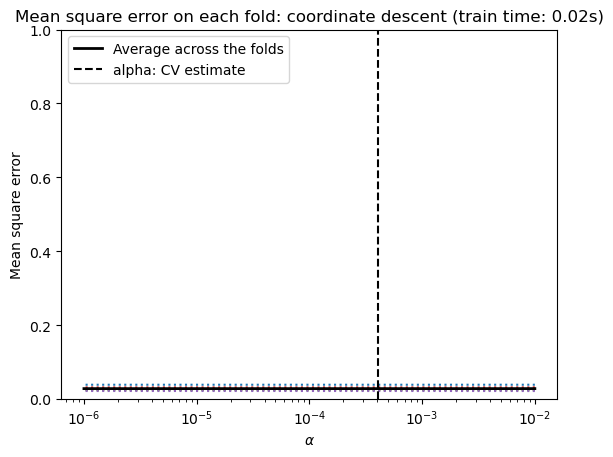

In [201]:
from sklearn.linear_model import MultiTaskLassoCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

start_time = time.time()
model = make_pipeline( MultiTaskLassoCV(alphas=np.logspace(-6, -2), cv=5, max_iter=10000, fit_intercept=False)).fit(x_train, y_train)
fit_time = time.time() - start_time
ymin, ymax = 0, 1
lasso = model[-1]
plt.figure()
plt.semilogx(lasso.alphas_, lasso.mse_path_, linestyle=":")
plt.plot(
    lasso.alphas_,
    lasso.mse_path_.mean(axis=-1),
    color="black",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(lasso.alpha_, linestyle="--", color="black", label="alpha: CV estimate")

plt.ylim(ymin, ymax)
plt.xlabel(r"$\alpha$")
plt.ylabel("Mean square error")
plt.legend()
_ = plt.title(
    f"Mean square error on each fold: coordinate descent (train time: {fit_time:.2f}s)"
)
#plt.savefig(save_path + case_name + '_lassoCV' + '.png')
#plt.close()
plt.show()

In [202]:
from sklearn.linear_model import lasso_path
from itertools import cycle
# # Compute paths

eps = 5e-3  # the smaller it is the longer is the path

print("Computing regularization path using the lasso...")
alphas_lasso, coefs_lasso, _ = lasso_path(x_train, y_train.reshape(-1), alphas=np.logspace(-6, -2),max_iter=10000, eps=eps)
plt.figure()
colors = cycle(["b", "r", "g", "c"])
names = ['S', r'$S^2$', 'A', 'Y']
neg_log_alphas_lasso = alphas_lasso # -np.log10(alphas_lasso)
for coef_l, c, name in zip(coefs_lasso, colors, names):
    l1 = plt.semilogx(neg_log_alphas_lasso, coef_l, c=c, label=name)
plt.axvline(lasso.alpha_, linestyle="--", color="black", label="alpha: CV estimate")
plt.xlabel(r"$\alpha$")
plt.ylabel("coefficients")
plt.title("Lasso Paths")
plt.legend(loc="lower left")
plt.axis("tight")
#plt.savefig(save_path + case_name + '_lassoPath' + '.png')
#plt.close()
plt.show()
#
final_lasso = linear_model.Lasso(alpha=lasso.alpha_, max_iter=10000, fit_intercept=False)
final_lasso.fit(x_train, y_train)
final_lasso.coef_
pd.DataFrame(final_lasso.coef_).to_csv(save_path + case_name + '_regression_coef.csv')

fig = plt.figure(figsize=(10,7))
for i in range(3):
    if i == 0:
        X, Y = np.meshgrid(s_grid, a_grid)
        Z = np.ones_like(X) * 0.0
        x_label, y_label = 'S', 'A'
    elif i == 1:
        X, Z = np.meshgrid(s_grid, y_grid)
        Y = np.ones_like(X) * 0.0
        x_label, y_label = 'S', 'Y'
    else:
        Y, Z = np.meshgrid(a_grid, y_grid)
        X = np.ones_like(Y) * 0.5
        x_label, y_label = 'A', 'Y'
    u_grid = np.stack([np.ravel(X), np.ravel(Y), np.ravel(Z)], axis=1)
    res_nn = contact_rate(u_grid)
    u_grid_lasso = np.stack([np.ravel(X), np.ravel(X)**2, np.ravel(Y), np.ravel(Z)], axis=1)
    res_lasso = final_lasso.predict(u_grid_lasso)
    res_lasso = res_lasso.reshape(X.shape)
    res_nn = res_nn[:,0].reshape(X.shape)
    ax = fig.add_subplot(1, 3, i + 1, projection='3d')
if i == 0:
    ax.plot_surface(X, Y, res_nn, cmap=cm.coolwarm, alpha=1)
    ax.scatter(X.reshape(-1), Y.reshape(-1), res_nn.reshape(-1), s=5, c='k')
    ax.plot_surface(X, Y, res_lasso, cmap=cm.coolwarm, alpha=1)
    ax.scatter(X.reshape(-1), Y.reshape(-1), res_lasso.reshape(-1), s=5, c='r')
elif i == 1:
    ax.plot_surface(X, Z, res_nn, cmap=cm.coolwarm, alpha=1)
    ax.scatter(X.reshape(-1), Z.reshape(-1), res_nn.reshape(-1), s=5, c='k')
    ax.scatter(X.reshape(-1), Z.reshape(-1), res_lasso.reshape(-1), s=5, c='r')
else:
    ax.plot_surface(Y, Z, res_nn, cmap=cm.coolwarm, alpha=1)
    ax.scatter(Y.reshape(-1), Z.reshape(-1), res_nn.reshape(-1), s=5, c='k')
    ax.scatter(Y.reshape(-1), Z.reshape(-1), res_lasso.reshape(-1), s=5, c='r')

ax.set_xlabel(x_label)
ax.set_ylabel(y_label)

fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
plt.tight_layout(pad=2)

Computing regularization path using the lasso...


ValueError: shapes (1,146) and (1314,) not aligned: 146 (dim 1) != 1314 (dim 0)